# Project 1 - Titanic Project

#### Kaggle Leaderboard Score: 0.78708

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

np.random.seed(11)

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

from feature_engine.encoding import RareLabelEncoder

from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

pd.set_option('display.max_columns',None)

In [2]:
train = pd.read_csv("train.csv").set_index("PassengerId")
test = pd.read_csv('test.csv').set_index('PassengerId')

In [3]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Explonatory Data Analysis

In [4]:
train.shape

(891, 11)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [6]:
train.isna().mean()

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

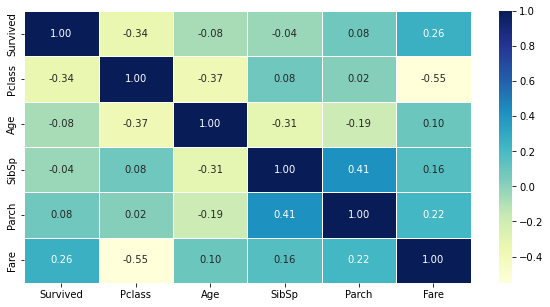

In [7]:
corr_matrix = train.corr()
plt.figure(figsize=(10,5))
sns.heatmap(corr_matrix, annot=True, linewidth=0.5, fmt='.2f',cmap='YlGnBu');

In [8]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

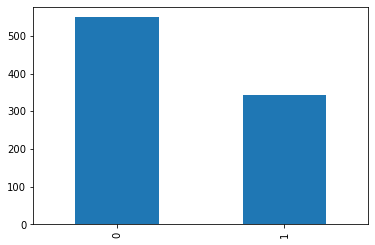

In [9]:
train['Survived'].value_counts().plot.bar();

In [10]:
print (train[["Pclass", "Survived"]].groupby(['Pclass'], as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


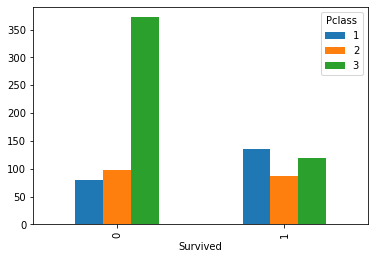

In [11]:
pd.crosstab(train['Survived'],train['Pclass']).plot(kind='bar');

In [12]:
print (train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


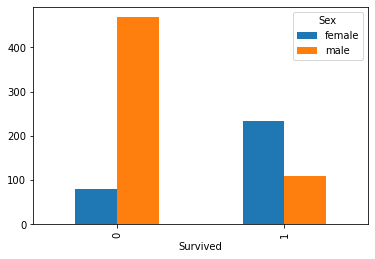

In [13]:
pd.crosstab(train['Survived'],train['Sex']).plot(kind='bar');

In [14]:
print (train[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957


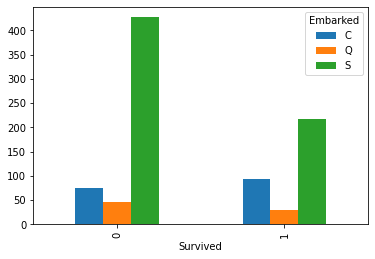

In [15]:
pd.crosstab(train['Survived'],train['Embarked']).plot(kind='bar');

In [16]:
print (train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean())

   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000


In [17]:
print (train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean())

   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000


In [18]:
print (train[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957


In [19]:
train.isna().mean()

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

In [20]:
train['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [21]:
X_train = train.drop(['Survived'],axis=1)
y_train = train['Survived']

In [22]:
X_train.shape, y_train.shape

((891, 10), (891,))

## Data preprocessing

In [23]:
X_train.drop(['Ticket'], inplace=True, axis=1)

### Impute 'Age' column with `99`

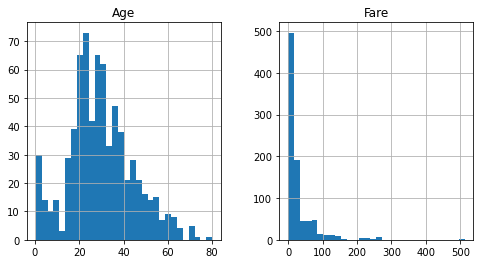

In [24]:
X_train[['Age','Fare']].hist(bins=30, figsize=(8,4));

In [25]:
pd.cut(X_train['Age'], 5).value_counts()

(16.336, 32.252]    346
(32.252, 48.168]    188
(0.34, 16.336]      100
(48.168, 64.084]     69
(64.084, 80.0]       11
Name: Age, dtype: int64

In [26]:
X_train["Age"] = X_train['Age'].fillna(99)

###  Discretize the Age Column

In [27]:
X_train.loc[X_train['Age'] <= 16, 'Age'] = 0
X_train.loc[(X_train['Age'] > 16) & (X_train['Age'] <= 32), 'Age'] = 1
X_train.loc[(X_train['Age'] > 32) & (X_train['Age'] <= 48), 'Age'] = 2
X_train.loc[(X_train['Age'] > 48) & (X_train['Age'] <= 64), 'Age'] = 3
X_train.loc[X_train['Age'] > 64, 'Age'] = 4

In [28]:
age_survival = pd.merge(X_train['Age'], y_train, left_index=True, right_index=True)
print (age_survival[['Age', "Survived"]].groupby(['Age'], as_index=False).mean())

   Age  Survived
0  0.0  0.550000
1  1.0  0.369942
2  2.0  0.404255
3  3.0  0.434783
4  4.0  0.281915


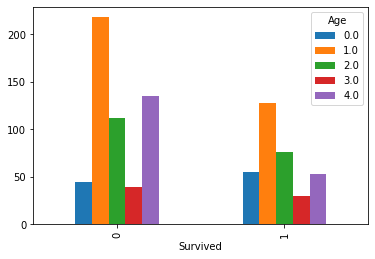

In [29]:
pd.crosstab(age_survival['Survived'],age_survival['Age']).plot(kind='bar');

In [30]:
## captures the first letter
X_train['Cabin_cat'] = X_train['Cabin'].str[0]
X_train.drop('Cabin', inplace=True, axis=1)
    
# #  captures numerical part
# X_train['Cabin_num'] = X_train['Cabin'].str.extract('(\d+)')

###  Dealing with missing values

In [31]:
num_impute = SimpleImputer(strategy='median')
relative_impute = SimpleImputer(strategy='most_frequent')
cat_impute = SimpleImputer(strategy='most_frequent')
cabin_impute = SimpleImputer(strategy='constant',fill_value='missing')

In [32]:
X_train['Fare'] = num_impute.fit_transform(X_train[['Fare']])
X_train[['SibSp','Parch']] = relative_impute.fit_transform(X_train[['SibSp','Parch']])
X_train[['Embarked','Pclass']] = cat_impute.fit_transform(X_train[['Embarked','Pclass']])
X_train['Cabin_cat'] = cabin_impute.fit_transform(X_train[['Cabin_cat']])

## Create  **Title** column

In [33]:
X_train['Title'] = X_train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
X_train.drop('Name', inplace=True,axis=1)

### Create  **Child_women**

In [34]:
X_train['Child_or_woman'] = np.where(((X_train['Age'] == 0) | (X_train['Sex'] == 'female')) ,1,0)

In [35]:
child_women = pd.merge(X_train['Child_or_woman'], y_train, left_index=True, right_index=True)
print (child_women[['Child_or_woman', "Survived"]].groupby(['Child_or_woman'], as_index=False).mean())

   Child_or_woman  Survived
0               0  0.165399
1               1  0.698630


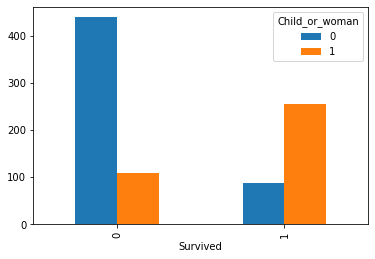

In [36]:
pd.crosstab(child_women['Survived'],child_women['Child_or_woman']).plot(kind='bar');

### Create **Relative** column

In [37]:
X_train['Relative'] = X_train['SibSp']+ X_train['Parch']
X_train.drop(['SibSp','Parch'], inplace=True,axis=1)

In [38]:
X_train.head()

,Pclass,Sex,Age,Fare,Embarked,Cabin_cat,Title,Child_or_woman,Relative
PassengerId,,,,,,,,,
1,3,male,1.0,7.2500,S,missing,Mr,0,1
2,1,female,2.0,71.2833,C,C,Mrs,1,1
3,3,female,1.0,7.9250,S,missing,Miss,1,0
4,1,female,2.0,53.1000,S,C,Mrs,1,1
5,3,male,2.0,8.0500,S,missing,Mr,0,0


In [39]:
relative_survival = pd.merge(X_train['Relative'], y_train, left_index=True, right_index=True)
print (relative_survival[['Relative', "Survived"]].groupby(['Relative'], as_index=False).mean())

   Relative  Survived
0         0  0.303538
1         1  0.552795
2         2  0.578431
3         3  0.724138
4         4  0.200000
5         5  0.136364
6         6  0.333333
7         7  0.000000
8        10  0.000000


## Create **Relative_less_than_four** column

In [40]:
X_train['Relative_less_than_four'] = np.where(((X_train['Relative'] > 0) & (X_train['Relative'] < 4)) ,1,0)

In [41]:
relative_survival_four = pd.merge(X_train['Relative_less_than_four'], y_train, left_index=True, right_index=True)
print (relative_survival_four[['Relative_less_than_four', "Survived"]].groupby(['Relative_less_than_four'], as_index=False).mean())

   Relative_less_than_four  Survived
0                        0  0.288815
1                        1  0.578767


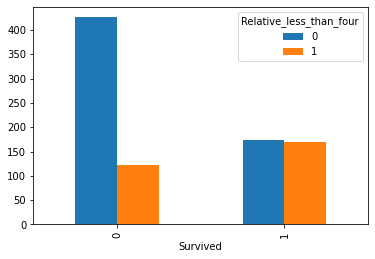

In [42]:
pd.crosstab(relative_survival_four['Survived'],relative_survival_four['Relative_less_than_four']).plot(kind='bar');

### Rare Label Encoding

In [43]:
rare_encoder = RareLabelEncoder(tol=0.05, n_categories=4, variables=['Title','Cabin_cat'])
rare_encoder.fit(X_train.fillna('Missing'))
X_train = rare_encoder.transform(X_train.fillna('Missing'))

### Create Survival Chance column

In [44]:
X_train['Survaival_chance'] = np.where(((X_train['Age'] == 0) | (X_train['Pclass'] == 1) | (X_train['Child_or_woman']==1) | (X_train['Title']=='Master') | (X_train['Title']=='Miss') | (X_train['Title']=='Mrs') | (X_train['Embarked']=='C') | (X_train['Relative_less_than_four']==1)),1,0)

In [45]:
X_train['Survaival_chance'].value_counts()

1    592
0    299
Name: Survaival_chance, dtype: int64

In [46]:
survaival_chance = pd.merge(X_train['Survaival_chance'], y_train, left_index=True, right_index=True)
print (survaival_chance[['Survaival_chance', "Survived"]].groupby(['Survaival_chance'], 
                                                                              as_index=False).mean())

   Survaival_chance  Survived
0                 0  0.107023
1                 1  0.523649


### OneHotEncoder

In [47]:
X_train.columns

Index(['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Cabin_cat', 'Title',
       'Child_or_woman', 'Relative', 'Relative_less_than_four',
       'Survaival_chance'],
      dtype='object')

In [48]:
cat_columns = ['Sex','Embarked','Title','Cabin_cat']

In [49]:
xindex = X_train.index

In [50]:
encoder = OneHotEncoder(categories='auto',sparse=False, handle_unknown='error')

In [51]:
one_hot = encoder.fit_transform(X_train[['Sex','Embarked','Title','Cabin_cat']])
one_hot = pd.DataFrame(one_hot, index=xindex)
one_hot.columns = encoder.get_feature_names_out()

In [52]:
X_train = X_train.drop(['Sex','Embarked','Title','Cabin_cat'], axis=1)

In [53]:
X_train = pd.merge(X_train, one_hot, left_index=True, right_index=True)

### Scalling

In [54]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, index=xindex)
X_train.columns = scaler.get_feature_names_out()

In [55]:
X_train.head()

,Pclass,Age,Fare,Child_or_woman,Relative,Relative_less_than_four,Survaival_chance,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Cabin_cat_B,Cabin_cat_C,Cabin_cat_Rare,Cabin_cat_missing
PassengerId,,,,,,,,,,,,,,,,,,,,
1,0.827377,-0.671036,-0.502445,-0.833016,0.059160,1.432260,0.710681,-0.737695,0.737695,-0.482043,-0.307562,0.615838,-0.506655,0.850532,-0.403962,-0.28515,-0.235981,-0.266296,-0.351541,0.544925
2,-1.566107,0.085791,0.786845,1.200457,0.059160,1.432260,0.710681,1.355574,-1.355574,2.074505,-0.307562,-1.623803,-0.506655,-1.175735,2.475480,-0.28515,-0.235981,3.755222,-0.351541,-1.835115
3,0.827377,-0.671036,-0.488854,1.200457,-0.560975,-0.698197,0.710681,1.355574,-1.355574,-0.482043,-0.307562,0.615838,1.973729,-1.175735,-0.403962,-0.28515,-0.235981,-0.266296,-0.351541,0.544925
4,-1.566107,0.085791,0.420730,1.200457,0.059160,1.432260,0.710681,1.355574,-1.355574,-0.482043,-0.307562,0.615838,-0.506655,-1.175735,2.475480,-0.28515,-0.235981,3.755222,-0.351541,-1.835115
5,0.827377,0.085791,-0.486337,-0.833016,-0.560975,-0.698197,-1.407101,-0.737695,0.737695,-0.482043,-0.307562,0.615838,-0.506655,0.850532,-0.403962,-0.28515,-0.235981,-0.266296,-0.351541,0.544925


## Feature Selection

In [56]:
X_data = X_train.copy()

In [57]:
constant_features = [feature for feature in X_data.columns if X_data[feature].nunique()==1]
len(constant_features)

0

In [58]:
quasi_constant_features = []

for feature in X_data.columns:
    predominant = X_data[feature].value_counts(normalize=True).sort_values(ascending=False).values[0]
    if predominant > 0.99:
        quasi_constant_features.append(feature)
len(quasi_constant_features)

0

In [59]:
quasi_constant_features

[]

In [60]:
duplicated_feat = []

for i in range(0, len(X_data.columns)):
    if i % 10 == 0: 
        print(i)

    col_1 = X_data.columns[i]

    for col_2 in X_data.columns[i + 1:]:
        if X_data[col_1].equals(X_data[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10


0

In [61]:
def correlation(df, threshold):
    col_corr = set()
    
    corr_matrix = df.corr()
    
    for i in range(len(corr_matrix.columns)):
        
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [62]:
corr_features = correlation(X_data, 0.8)
print(f'correlated features: {len(set(corr_features))}')

correlated features: 3


In [63]:
set(corr_features)

{'Sex_female', 'Sex_male', 'Title_Mr'}

In [64]:
mi = mutual_info_regression(X_train, y_train)
mi

array([0.08237266, 0.00179456, 0.14013291, 0.14995674, 0.03719296,
       0.03102446, 0.05617951, 0.17012034, 0.15766381, 0.06206418,
       0.00078893, 0.        , 0.07781578, 0.11874972, 0.08212418,
       0.        , 0.00669617, 0.00969413, 0.01005758, 0.04059749])

Text(0, 0.5, 'Mutual Information')

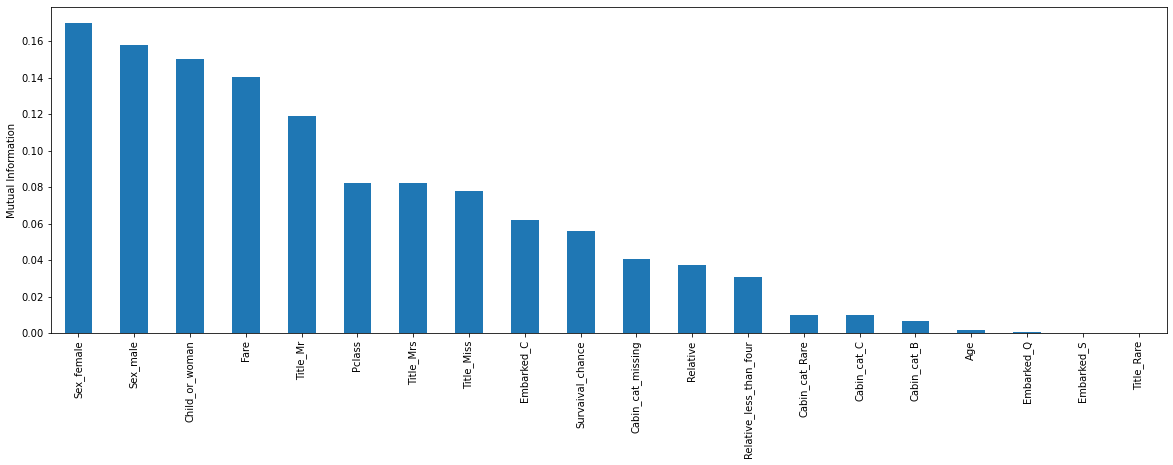

In [65]:
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20,6))
plt.ylabel('Mutual Information')

In [66]:
sel = SelectKBest(mutual_info_regression, k=18).fit(X_train, y_train)

In [67]:
selected_columns = X_train.columns[sel.get_support()]

In [68]:
selected_columns

Index(['Pclass', 'Age', 'Fare', 'Child_or_woman', 'Relative',
       'Relative_less_than_four', 'Survaival_chance', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare',
       'Cabin_cat_B', 'Cabin_cat_C', 'Cabin_cat_Rare', 'Cabin_cat_missing'],
      dtype='object')

In [69]:
X_train = X_train[selected_columns]

In [70]:
X_train.head()

,Pclass,Age,Fare,Child_or_woman,Relative,Relative_less_than_four,Survaival_chance,Sex_female,Sex_male,Embarked_C,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Cabin_cat_B,Cabin_cat_C,Cabin_cat_Rare,Cabin_cat_missing
PassengerId,,,,,,,,,,,,,,,,,,
1,0.827377,-0.671036,-0.502445,-0.833016,0.059160,1.432260,0.710681,-0.737695,0.737695,-0.482043,-0.506655,0.850532,-0.403962,-0.28515,-0.235981,-0.266296,-0.351541,0.544925
2,-1.566107,0.085791,0.786845,1.200457,0.059160,1.432260,0.710681,1.355574,-1.355574,2.074505,-0.506655,-1.175735,2.475480,-0.28515,-0.235981,3.755222,-0.351541,-1.835115
3,0.827377,-0.671036,-0.488854,1.200457,-0.560975,-0.698197,0.710681,1.355574,-1.355574,-0.482043,1.973729,-1.175735,-0.403962,-0.28515,-0.235981,-0.266296,-0.351541,0.544925
4,-1.566107,0.085791,0.420730,1.200457,0.059160,1.432260,0.710681,1.355574,-1.355574,-0.482043,-0.506655,-1.175735,2.475480,-0.28515,-0.235981,3.755222,-0.351541,-1.835115
5,0.827377,0.085791,-0.486337,-0.833016,-0.560975,-0.698197,-1.407101,-0.737695,0.737695,-0.482043,-0.506655,0.850532,-0.403962,-0.28515,-0.235981,-0.266296,-0.351541,0.544925


In [71]:
class PreProcessing(BaseEstimator,TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.drop(['Ticket'], inplace=True, axis=1)
        X["Age"] = X['Age'].fillna(99)
        
        X.loc[X['Age'] <= 16, 'Age'] = 0
        X.loc[(X['Age'] > 16) & (X['Age'] <= 32), 'Age'] = 1
        X.loc[(X['Age'] > 32) & (X['Age'] <= 48), 'Age'] = 2
        X.loc[(X['Age'] > 48) & (X['Age'] <= 64), 'Age'] = 3
        X.loc[X['Age'] > 64, 'Age'] = 4
        
        X['Cabin_cat'] = X['Cabin'].str[0]
        X.drop('Cabin', inplace=True, axis=1)
        
        X['Fare'] = num_impute.transform(X[['Fare']])
        X[['SibSp','Parch']] = relative_impute.transform(X[['SibSp','Parch']])
        X[['Embarked','Pclass']] = cat_impute.transform(X[['Embarked','Pclass']])
        X['Cabin_cat'] = cabin_impute.transform(X[['Cabin_cat']])
        
        X['Title'] = X['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
        X.drop('Name', inplace=True,axis=1)
        
        X['Child_or_woman'] = np.where(((X['Age'] == 0) | (X['Sex'] == 'female')) ,1,0)
        
        X['Relative'] = X['SibSp']+ X['Parch']
        X.drop(['SibSp','Parch'],inplace=True, axis=1)
        
        X['Relative_less_than_four'] = np.where(((X['Relative'] > 0) & (X['Relative'] < 4)) ,1,0)
        
        X = rare_encoder.transform(X.fillna('Missing'))
        
        X['Survaival_chance'] = np.where(((X['Age'] == 0) | (X['Pclass'] == 1) | (X['Child_or_woman']==1) | (X['Title']=='Master') | (X['Title']=='Miss') | (X['Title']=='Mrs') | (X['Embarked']=='C') | (X['Relative_less_than_four']==1)),1,0)
        
        return X
        
class OneHot(BaseEstimator,TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        xindex = X.index
        
        one_hot = encoder.transform(X[['Sex','Embarked','Title','Cabin_cat']])
        one_hot = pd.DataFrame(one_hot, index=xindex)
        one_hot.columns = encoder.get_feature_names_out()
        
        X = X.drop(['Sex','Embarked','Title','Cabin_cat'], axis=1)
        
        X = pd.merge(X, one_hot, left_index=True, right_index=True) 
        
        X = scaler.transform(X)
        X = pd.DataFrame(X, index=xindex)
        X.columns = scaler.get_feature_names_out()
        
        return X
    
class Feature_selection(BaseEstimator,TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X[selected_columns]
        
        return X
        

In [72]:
pipe = Pipeline([
    ('preprocessing', PreProcessing()),
    ('encoding', OneHot()),
    ('feature_selection',Feature_selection()),
])

## Create a new train set and add preprocessing steps

In [73]:
X_train = train.drop(['Survived'],axis=1)
X_train = pipe.fit_transform(X_train)

## Application of ML models

In [74]:
model_xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=11)
cross_check_xgb = cross_val_score(model_xgb,X_train, y_train, cv=10)
cross_check_xgb.mean()

0.8227215980024969

In [75]:
model_svm = SVC(random_state=42)
cross_check_svm = cross_val_score(model_svm,X_train, y_train, cv=10)
cross_check_svm.mean()

0.8294132334581772

In [76]:
model_reg = LogisticRegression()
cross_check_reg = cross_val_score(model_reg,X_train, y_train, cv=10)
cross_check_reg.mean()

0.8271910112359551

In [77]:
model_rf = RandomForestClassifier()
cross_check_rf = cross_val_score(model_rf,X_train, y_train, cv=10)
cross_check_rf.mean()

0.8137078651685394

In [78]:
#               params={'gamma': [0,0.01,0.05,0.1,0.5,1,2,3],
#                     'colsample_bynode':[0.5,0.6,0.7,0.8,0.9,1],
#                     'colsample_bytree':[0.5,0.6,0.7,0.8,0.9,1],
#                     'colsample_bylevel':[0.5,0.6,0.7,0.8,0.9,1],
#                     'subsample':[0.5,0.6,0.7,0.8,0.9,1],
#                     'min_child_weight':[1,2,3,4,5],
#                     'learning_rate':[0.1,0.2,0.3,0.4,0.5],
#                     'max_depth':[1,2,3,4,5,6,7,8,9,None],
#                     'n_estimators': [5,10,15,20,25,50,100,200,400,800]},
#            random=True)

In [79]:
params = {'gamma': [0.05],
          'colsample_bylevel':[0.9],
          'subsample':[0.8],
          'max_depth':[5],
          'n_estimators': [5]
}

In [80]:
# xgb = XGBClassifier(booster='gbtree', objective='binary:logistic',random_state=11)
# kfold = StratifiedKFold(n_splits=5,shuffle=True, random_state=11)
# grid = GridSearchCV(xgb, params, cv=kfold, n_jobs=-1)
# grid.fit(X_train, y_train)
# best_params = grid.best_params_
# print("Best params: ", best_params) 
# best_score = grid.best_score_
# print(f"Best score: {best_score:.5f}")

In [81]:
model_xgb = XGBClassifier(booster='gbtree', objective='binary:logistic',
                           max_depth=4, n_estimators=50, subsample=0.9,colsample_bylevel=1,
                         gamma=0.1, random_state=11,learning_rate=0.1)
model_xgb.fit(X_train, y_train)
cross_check_xgb = cross_val_score(model_xgb, X_train, y_train, cv=10)
cross_check_xgb.mean()

0.8373158551810237

In [82]:
# param_grid = [
#     {'C':[0.1,0.4,0.5,0.6,0.7],
#     'gamma':[0.01,0.08,0.09,0.1,0.2],
#     'kernel':['poly', 'rbf', 'sigmoid']},
# ]

# optimal_params_svm = GridSearchCV(SVC(), param_grid, cv=10, scoring='accuracy',verbose=0)
# optimal_params_svm.fit(X_train, y_train)
# print(optimal_params_svm.best_params_)

In [83]:
model_svm = SVC(random_state=11,gamma=0.15, C=0.7, kernel='rbf')
model_svm.fit(X_train, y_train)
cross_check_svm = cross_val_score(model_svm, X_train, y_train, cv=10)
cross_check_svm.mean()

0.832784019975031

In [84]:
# param_lin = [
#     {'solver': ['newton-cg','liblinear'],
#     'penalty': ['l2'],
#      'C': [100, 10, 1.0, 0.1, 0.01]},
# ]

# optimal_params_lin = GridSearchCV(LogisticRegression(), param_lin, cv=10, scoring='accuracy',verbose=0)
# optimal_params_lin.fit(X_train, y_train)
# print(optimal_params_lin.best_params_)

In [85]:
model_reg = LogisticRegression(C=0.1, penalty='l2', solver='newton-cg')
model_reg.fit(X_train, y_train)
cross_check_reg = cross_val_score(model_reg,X_train, y_train, cv=10)
cross_check_reg.mean()

0.830561797752809

In [86]:
# grid_search(params={'min_samples_split':[2,4,10,14,18],
#                    'min_samples_leaf':[1,5,10,15],
#                     'max_depth':[1,2,3,4,5,6,7,8,9,None],
#                     'n_estimators': [5,10,25,50,75,100]},
#            random=True)

In [87]:
params_rf={'n_estimators': [5,10,25,50,75,100]
          }

In [88]:
# rf = RandomForestClassifier(random_state=11)
# kfold = StratifiedKFold(n_splits=5,shuffle=True, random_state=11)
# grid = GridSearchCV(rf, params_rf, cv=kfold, n_jobs=-1)
# grid.fit(X_train, y_train)
# best_params = grid.best_params_
# print("Best params: ", best_params)
# best_score = grid.best_score_
# print(f"Best score: {best_score:.5f}")

In [89]:
model_rf = RandomForestClassifier(max_depth=7, min_samples_leaf=2, min_samples_split=5, n_estimators=60, random_state=11)
cross_check_rf = cross_val_score(model_rf,X_train, y_train, cv=10)
cross_check_rf.mean()

0.8316853932584269

## Ensemble Methods

In [90]:
model = VotingClassifier([
    ('xgb',model_xgb),
    ('svm',model_svm),
    ('reg',model_reg),
    ('rf',model_rf)
], voting='hard')

cross_check_ensemble = cross_val_score(model, X_train, y_train, cv=10)
cross_check_ensemble.mean()

0.8283270911360798

In [91]:
model.fit(X_train, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=0.1,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.1, max_bin=256,
                                            max_...
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=50, n_jobs=0,
                                            num_parallel_tree=1,
                                            predictor='auto', random_state=11,
                                            reg_alpha=0, reg_lambda=1, ...)),
                             ('svm', SVC(C=0.7, gamma=0.15, random_state=11)),
                             ('reg',
                              LogisticRegression(C=0.1, solver='newton-cg')),
                             ('rf',
                              RandomForestClassifier(max_depth=7,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     n_estimators=60,
                                                     random_state=11))])

In [92]:
test_id = test.index

In [93]:
test = pipe.transform(test)

In [94]:
test_pred_ensemble = model.predict(test)

In [95]:
test_pred_ensemble = pd.Series(test_pred_ensemble)

In [96]:
Pasenger_no = pd.Series(test_id)

In [97]:
ensemble = pd.DataFrame({'PassengerId':test_id.values, 'Survived':test_pred_ensemble.values}).set_index("PassengerId")

In [98]:
ensemble.to_csv('Titanic - Classification Project.csv')

### Kaggle Leaderboard Score: 0.78708